In [1]:
from statistics import mean, stdev
import numpy as np
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, lars_path, ElasticNet

from functions.plotting import plot_empty, plot_single_scatter

with open('.db/postgres.json') as f:
    cred = json.load(f)
    username = cred.get("user")
    password = cred.get("password")
    host = cred.get("host")
    port = cred.get("port")
    
db_name = "mountain_project"
connection_str = f'postgres://{username}:{password}@{host}:{port}/{db_name}' # sqlalchemy connection args

In [2]:
save=True

# Get Data

In [3]:
query = """
SELECT b.avg_stars, b.length_, b.grade,
       r.star_ratings, r.on_to_do_lists, r.ticks
FROM routes b
LEFT JOIN ratings r ON b.url_id = r.url_id
WHERE b.area_name IN ('buttermilks', 'druid_stones', 'happy_boulders', 'sad_boulders')
  AND length_ IS NOT NULL
;
"""
data_df = pd_sql.read_sql(query, connection_str) # grab data as a dataframe
data_df = data_df.reset_index(drop=True)
data_df.head()

,avg_stars,length_,grade,star_ratings,on_to_do_lists,ticks
0,1.3,10.0,-1.00,30,8,52
1,2.0,15.0,-1.00,1,0,1
2,2.2,18.0,-0.25,41,11,87
3,2.8,18.0,-0.25,84,49,168
4,1.8,12.0,-0.25,46,12,102


# Linear Regression

In [4]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

In [5]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['on_to_do_lists']), data_df['on_to_do_lists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['star_ratings', 'ticks', 'avg_stars', 'length_', 'grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

In [6]:
# Scikit Learn's LinearRegression

# Initialize Model
linreg =  LinearRegression()
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Standard Scaler on Features
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)
    
    # Fit model
    linreg.fit(features_train_cv_scaled_array, target_train_cv_array)
    
    # Collect results
    SSE = sum((target_val_cv_array - linreg.predict(features_val_cv_scaled_array))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_score = 1-SSE/SST
    r2_cv_list.append(r2_cv_score)

print(r2_cv_list)
print('r2_cv_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)
linreg.fit(features_train_scaled_array, target_train_ser) # Fit model

SSE = sum((target_test_ser - linreg.predict(features_test_scaled_array))**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)
r2_test_score = 1-SSE/SST

print('r2_test_score: ', r2_test_score) #Get score
print(linreg.coef_)

[0.870922334805144, 0.7399871526811761, 0.6989487934992048, 0.8098125189399525, 0.8057584444136068]
r2_cv_score:  0.7850858488678168  +/-  0.0668209387894904
r2_test_score:  0.6426057149839706
[ 162.79335556 -119.0719405     3.35828707    0.93340456    0.2348178 ]


In [7]:
# Statsmodels OLS

r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((target_val_cv_array - ols_results.predict(sm.add_constant(features_val_cv_scaled_array)))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array))
ols_results = ols_model.fit()

# Collect results on the test set
SSE = sum((target_test_ser - ols_results.predict(sm.add_constant(features_test_scaled_array)))**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[1:]))

[0.8709223348051447, 0.7399871526811767, 0.6989487934992047, 0.8098125189399511, 0.8057584444136074]
val_r2_score:  0.785085848867817  +/-  0.06682093878949048
test_r2_score:  0.6426057149839713
[162.79335555922538, -119.07194050384435, 3.358287071703185, 0.9334045637874373, 0.23481779862511942]


In [8]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:         on_to_do_lists   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     638.8
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          8.91e-277
Time:                        21:19:53   Log-Likelihood:                -3755.7
No. Observations:                 808   AIC:                             7523.
Df Residuals:                     802   BIC:                             7552.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1089      0.892     22.545      0.0

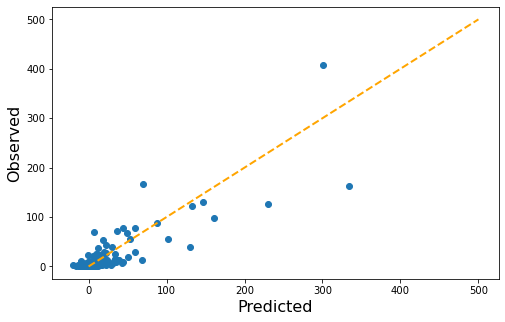

In [9]:
x = ols_results.predict(sm.add_constant(features_test_scaled_array))
y = target_test_ser
feature_target_df = pd.DataFrame({'predicted': x, 'observed': y})

fig = plot_single_scatter(feature_target_df, 'predicted', 'observed',
                          xlabel='Predicted', ylabel='Observed',
                          color=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")

if save:
    plt.savefig("figures/linear/observed-vs-predicted.png", transparent=True, bbox_inches="tight")

# Ridge

In [10]:
# Ridge Gridsearch

alpha_list = 10**(np.linspace(-2,5,201)) # Generate a list of 10^(x) 
mae_list, r2_list, coefs_list = [], [], []

for i,curr_alpha in enumerate(alpha_list):
    
    # Initialize Model
    ridgereg = Ridge(alpha = curr_alpha, random_state=123)
    mae_cv_list, r2_cv_list, coefs_cv_list = [], [], [] # Collect the cross-validation results
    
    for train_index, val_index in kf.split(features_train_chosen_array, target_train_array):
        
        # Make split
        features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
        features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_index], target_train_array[val_index] 

        # Standard Scaler on Features
        features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
        features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

        # Fit model
        ridgereg.fit(features_train_cv_scaled_array, target_train_cv_array)
        target_val_cv_predict_array = ridgereg.predict(features_val_cv_scaled_array)
        
        # Collect results
        mae_cv_list.append(np.mean(np.abs(target_val_cv_predict_array - target_val_cv_array)))
        r2_cv_list.append(ridgereg.score(features_val_cv_scaled_array, target_val_cv_array))
        coefs_cv_list.append(ridgereg.coef_)
        
    # Collect Results Average for K-Fold Cross Validation
    mae_list.append(np.mean(mae_cv_list))
    r2_list.append(mean(r2_cv_list))
    coefs_cv_array = np.stack(coefs_cv_list, axis = 0)
    coefs_cv_mean_array = np.mean(coefs_cv_array, axis = 0)
    coefs_list.append(coefs_cv_mean_array)
    
# Print alpha value that gave the lowest mean absolute error
alpha_min_mae = alpha_list[np.argmin(mae_list)]
print(alpha_min_mae)

1.6032453906900417


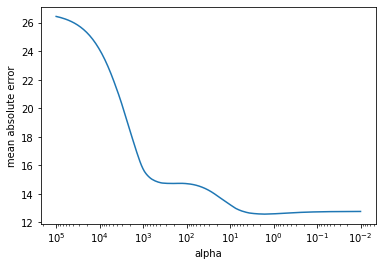

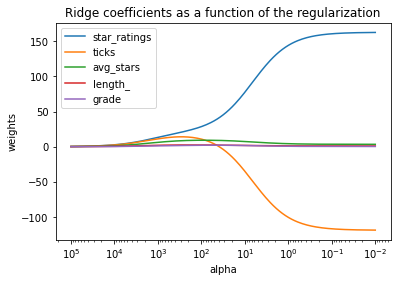

In [11]:
# plot validation error with changing alpha
alpha_mae_df = pd.DataFrame({'alpha': alpha_list, 'mean_absolute_error': mae_list})
fig, ax = plot_empty(xlabel='alpha', ylabel='mean absolute error', figsize=None)
ax.plot(alpha_list, mae_list)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
if save:
    plt.savefig("figures/ridge/mae-vs-alpha.png", transparent=True, bbox_inches="tight")
    
# Plot the coefficients as the alphas change
fig, ax = plot_empty(xlabel='alpha', ylabel='weights',
                     title='Ridge coefficients as a function of the regularization',
                     figsize=None,
                    )
ax.plot(alpha_list, coefs_list[:])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.legend(features_train_chosen_df.columns)
plt.axis('tight')
if save:
    plt.savefig("figures/ridge/weights-vs-alpha.png", transparent=True, bbox_inches="tight")

Optimal Ridge Regression

In [12]:
# Ridge Regression
ridgereg = Ridge(alpha=alpha_min_mae)

# KFold Cross-Validation
cv_r2_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ridgereg.fit(features_train_cv_scaled_array, target_train_cv_array) # Fit model
    cv_r2_list.append(ridgereg.score(features_val_cv_scaled_array, target_val_cv_array)) # Collect results

print(cv_r2_list)
print('val_r2_score: ', mean(cv_r2_list),' +/- ', stdev(cv_r2_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)
ridgereg.fit(features_train_scaled_array, target_train_ser) # Fit model

print('test_r2_score: ', ridgereg.score(features_test_scaled_array, target_test_ser)) #Get score
print(ridgereg.coef_)

[0.8702136451775294, 0.7311377788741845, 0.6806860129977363, 0.7965607342562644, 0.8506887116156361]
val_r2_score:  0.7858573765842701  +/-  0.07982620811892929
test_r2_score:  0.6582658734198538
[139.91491423 -96.50583641   4.43967005   1.17183445   0.60434823]


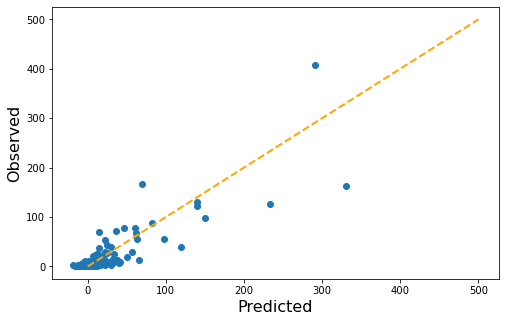

In [13]:
x = ridgereg.predict(features_test_scaled_array)
y = target_test_ser
feature_target_df = pd.DataFrame({'predicted': x, 'observed': y})

fig = plot_single_scatter(feature_target_df, 'predicted', 'observed',
                          xlabel='Predicted', ylabel='Observed',
                          color=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")

if save:
    plt.savefig("figures/ridge/observed-vs-predicted.png", transparent=True, bbox_inches="tight")

# Lasso

In [14]:
# Lasso Gridsearch

alpha_list = 10**(np.linspace(-5,0,201)) # Generate a list of 10^(x) 
mae_list, r2_list, coefs_list = [], [], []

for i,curr_alpha in enumerate(alpha_list):
    
    # Initialize Model
    lasso_model = Lasso(alpha = curr_alpha, random_state=123)
    
    mae_cv_list, r2_cv_list, coefs_cv_list = [], [], [] # Collect the cross-validation results
    
    for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
        
        # Make split
        features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
        features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

        # Standard Scaler on Features
        features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
        features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

        # Fit model
        lasso_model.fit(features_train_cv_scaled_array, target_train_cv_array)
        target_val_cv_predict_array = lasso_model.predict(features_val_cv_scaled_array)
        
        # Collect results
        mae_cv_list.append(np.mean(np.abs(target_val_cv_predict_array - target_val_cv_array)))
        r2_cv_list.append(lasso_model.score(features_val_cv_scaled_array, target_val_cv_array))
        coefs_cv_list.append(lasso_model.coef_)
        
    # Collect Results Average for K-Fold Cross Validation
    mae_list.append(np.mean(mae_cv_list))
    r2_list.append(mean(r2_cv_list))
    coefs_cv_array = np.stack(coefs_cv_list, axis = 0)
    coefs_cv_mean_array = np.mean(coefs_cv_array, axis = 0)
    coefs_list.append(coefs_cv_mean_array)

# Print alpha value that gave the lowest mean absolute error
alpha_min_mae = alpha_list[np.argmin(mae_list)]
print(alpha_min_mae)

0.4466835921509635


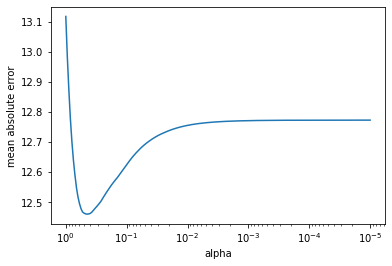

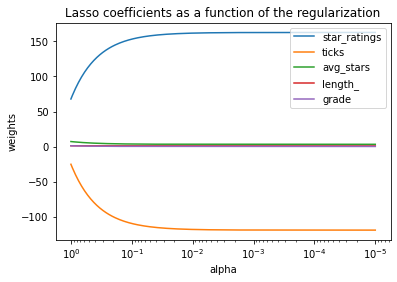

In [15]:
# plot validation error with changing alpha
alpha_mae_df = pd.DataFrame({'alpha': alpha_list, 'mean_absolute_error': mae_list})
fig, ax = plot_empty(xlabel='alpha', ylabel='mean absolute error', figsize=None)
ax.plot(alpha_list, mae_list)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
if save:
    plt.savefig("figures/lasso/mae-vs-alpha.png", transparent=True, bbox_inches="tight")
    
# Plot the coefficients as the alphas change
fig, ax = plot_empty(xlabel='alpha', ylabel='weights',
                     title='Lasso coefficients as a function of the regularization',
                     figsize=None
                    )
ax.plot(alpha_list, coefs_list[:])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.legend(features_train_chosen_df.columns)
plt.axis('tight')

if save:
    plt.savefig("figures/lasso/weights-vs-alpha.png", transparent=True, bbox_inches="tight")

Optimize Lasso Regression

In [16]:
# Lasso
lasso_model = Lasso(alpha = alpha_min_mae)

# KFold Cross-Validation

cv_r2_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    lasso_model.fit(features_train_cv_scaled_array, target_train_cv_array) # Fit model
    cv_r2_list.append(lasso_model.score(features_val_cv_scaled_array, target_val_cv_array)) # Collect results
    
print(cv_r2_list)
print('val_r2_score: ', mean(cv_r2_list),' +/- ', stdev(cv_r2_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)
lasso_model.fit(features_train_scaled_array, target_train_ser) # Fit model

print('test_r2_score: ', lasso_model.score(features_test_scaled_array, target_test_ser)) #Get score
print(lasso_model.coef_) #Get score

[0.8649885404332671, 0.7202993142291523, 0.6628631104482472, 0.7859257549212856, 0.862695767056914]
val_r2_score:  0.7793544974177732  +/-  0.08857185765375242
test_r2_score:  0.6646699046091015
[120.74689983 -77.46670644   5.10345806   1.06560837   0.65572587]


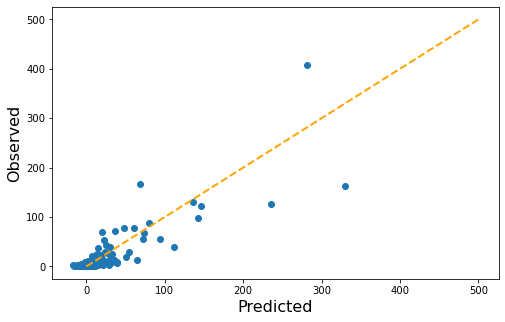

In [17]:
x = lasso_model.predict(features_test_scaled_array)
y = target_test_ser
feature_target_df = pd.DataFrame({'predicted': x, 'observed': y})

fig = plot_single_scatter(feature_target_df, 'predicted', 'observed',
                          xlabel='Predicted', ylabel='Observed',
                          color=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")

if save:
    plt.savefig("figures/lasso/observed-vs-predicted.png", transparent=True, bbox_inches="tight")

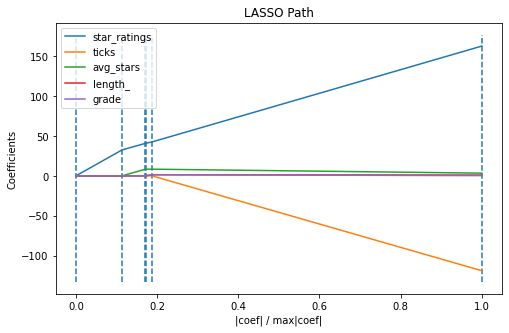

In [18]:
# Compute regularization path for Lasso using the LARS
alphas_array, active_indices_list, coefs_array = lars_path(features_train_scaled_array, target_train_ser.values, method='lasso')
x = np.sum(np.abs(coefs_array.T), axis=1)
x /= x.max() # normalize by max

# Plot
fig = plot_empty('|coef| / max|coef|', 'Coefficients', 'LASSO Path')
plt.plot(x, coefs_array.T)
ymin, ymax = plt.ylim()
plt.vlines(x, ymin, ymax, linestyle='dashed')
plt.axis('tight')
plt.legend(features_train_chosen_df.columns)

if save:
    plt.savefig("figures/lasso/lasso-lars-path.png", transparent=True, bbox_inches="tight")

# ElasticNet

In [19]:
# ElasticNet
elastic_net = ElasticNet(random_state=1)

# KFold Cross-Validation
cv_r2_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    elastic_net.fit(features_train_cv_scaled_array, target_train_cv_array) # Fit model
    cv_r2_list.append(elastic_net.score(features_val_cv_scaled_array, target_val_cv_array)) # Collect results
    
print(cv_r2_list)
print('val_r2_score: ', mean(cv_r2_list),' +/- ', stdev(cv_r2_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)
elastic_net.fit(features_train_scaled_array, target_train_ser) # Fit model

print('test_r2_score: ', elastic_net.score(features_test_scaled_array, target_test_ser)) #Get score
print(elastic_net.coef_)

[0.7001556134497001, 0.6866512457870225, 0.5078448644220708, 0.6093298506423471, 0.8157690370939162]
val_r2_score:  0.6639501222790114  +/-  0.11426656017757014
test_r2_score:  0.6593465705847543
[19.75126582 13.75492299  8.23331939  2.12203698  1.26873922]


In [20]:
# Statsmodels Elastic Net

r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array))
    ols_results = ols_model.fit_regularized(alpha=1, L1_wt = 0.5) # Fit model
    
    # Collect results on the validation set
    SSE = sum((target_val_cv_array - ols_results.predict(sm.add_constant(features_val_cv_scaled_array)))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array))
ols_results = ols_model.fit_regularized(alpha=1, L1_wt = 0.5)

# Collect results on the test set
SSE = sum((target_test_ser - ols_results.predict(sm.add_constant(features_test_scaled_array)))**2)
SST = sum((target_test_ser - np.mean(target_test_ser))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[1:]))

[0.6871345612574634, 0.6917005850597873, 0.49062326526523714, 0.5882322121580693, 0.7895719265480204]
val_r2_score:  0.6494525100577155  +/-  0.1138122813867808
test_r2_score:  0.6455970848299133
[19.750482848048794, 13.755394595294872, 8.233415129570187, 2.1220489439078367, 1.2687052588142056]
